In [1]:
import pandas as pd 
import seaborn as sns 
import numpy as np 
import matplotlib.pyplot as plt
import mysql.connector


In [2]:
def make_connection_with_db():
    connection = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",
    database="wp_ecommerce")
    cursor = connection.cursor(dictionary=True)
    return connection,cursor 



In [29]:

def get_user_profile():
    """
    Retrieves user profile data (country, age, gender) from wp_users and wp_usermeta tables
    and returns it as a Pandas DataFrame.
    """
    connection = None
    cursor = None
    df = pd.DataFrame(columns=['user_id', 'country', 'age', 'gender'])

    try:
        connection, cursor = make_connection_with_db()

        # Step 1: Get all user IDs from wp_users
        sql_users = "SELECT ID FROM wp_users"
        cursor.execute(sql_users)
        # Fetchall returns a list of dictionaries if dictionary=True is set for cursor
        user_ids_data = cursor.fetchall()

        if not user_ids_data:
            print("No users found in wp_users table.")
            return df # Return empty DataFrame

        # Extract just the IDs into a list
        user_ids = [user['ID'] for user in user_ids_data]

        # Step 2: Get all relevant user metadata in a single query
        # Using a parameterized query for safety and efficiency with IN clause
        placeholders = ', '.join(['%s'] * len(user_ids))
        sql_usermeta = f"""
            SELECT user_id, meta_key, meta_value
            FROM wp_usermeta
            WHERE user_id IN ({placeholders})
            AND meta_key IN ('country', 'age', 'gender');
        """
        cursor.execute(sql_usermeta, tuple(user_ids))
        all_usermeta = cursor.fetchall() # Returns list of dictionaries

        # Step 3: Process the fetched data into a structured format
        # Initialize a dictionary for each user with default None values
        user_profiles = {user_id: {'user_id': user_id, 'country': None, 'age': None, 'gender': None}
                         for user_id in user_ids}

        # Populate the user_profiles dictionary with fetched meta_values
        for row in all_usermeta:
            user_id = row['user_id']
            meta_key = row['meta_key']
            meta_value = row['meta_value']

            if meta_key in user_profiles[user_id]: # Ensure we only store expected keys
                if meta_key == 'age':
                    user_profiles[user_id][meta_key] = int(meta_value)
                else:    
                    user_profiles[user_id][meta_key] = meta_value

        # Step 4: Convert the structured data into a Pandas DataFrame
        df = pd.DataFrame(list(user_profiles.values()))

    except mysql.connector.Error as err:
        print(f"Database error: {err}")
        # Optionally, log the error for debugging
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        # Optionally, log the error for debugging
    finally:
        # Ensure cursor and connection are closed
        if cursor:
            cursor.close()
        if connection:
            connection.close()
    return df

In [26]:
df=get_user_profile()
df.sort_values('age',ascending=False)
# # Convert to numeric, coercing errors to NaN
# # This turns '40.5' into 40.5 and 'abc' into NaN
# df['age'] = pd.to_numeric(df['age'], errors='coerce')

df


,user_id,country,age,gender
0,1501,JO,33,ذكر
1,1784,JO,30,ذكر
2,1109,AE,37,انثى
3,112,BH,55,انثى
4,1115,JO,29,ذكر
...,...,...,...,...
1497,892,AE,30,انثى
1498,91,SA,41,ذكر
1499,910,BH,44,انثى
1500,931,SA,48,انثى


In [30]:
def show_user_histgoram(): 
    df = get_user_profile()
    # df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df_age = df['age']

    df_age.hist(bins=[0,10,20,30,40,50,60,70,80])
    plt.xlabel('Age')
    plt.ylabel("Count")

    plt.title("Users Age Histogram")
    plt.show()
    

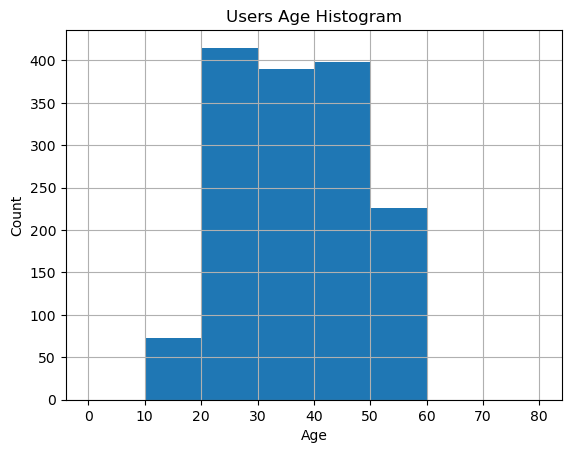

In [31]:
show_user_histgoram()

In [38]:
def show_user_desnsity(): 
    df = get_user_profile()
    # df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df_age = df['age']

    df_age.plot(kind='density')
    plt.xlabel('Age')
    plt.ylabel("Density")

    plt.title("Users Age Density")
    plt.show()
    

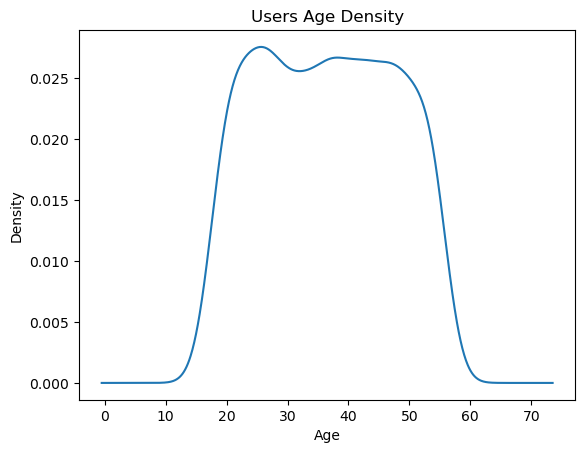

In [39]:
show_user_desnsity()

In [66]:
def show_user_gender_pie(): 
    df = get_user_profile() 
    if df.empty:
        print("No user data available to generate gender pie chart.")
        return

    # # Standardize gender values (e.g., to lowercase) and map common variations
    # # This helps ensure consistency if gender data isn't perfectly clean
    # df['gender'] = df['gender'].astype(str).str.lower().replace({
    #     'ذكر': 'male',
    #     'انثى': 'female',
    #     'm': 'male',
    #     'f': 'female',
    #     'ذكر ': 'male', # Handle extra spaces
    #     'انثى ': 'female'
    # })
    # X = df[['gender','user_id']].groupby('gender').count()
    
    import arabic_reshaper 
    from bidi.algorithm import get_display 
    df['gender'] = df['gender'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    X = df['gender'].value_counts()
 
    plt.figure(figsize=(10,7))
    plt.pie(X.values,labels=X.index,autopct='%0.1f%%')
    
    plt.show()

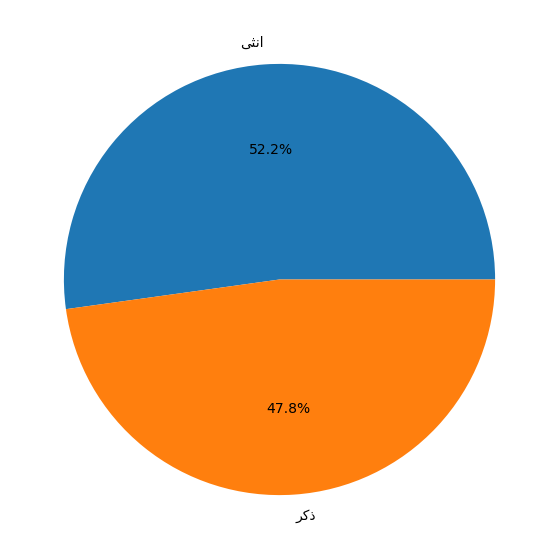

In [67]:
show_user_gender_pie()

In [55]:
# pip install arabic-reshaper

In [53]:
# !pip install python-bidi

In [60]:
def show_user_gender_pie_en(): 
    df = get_user_profile() 
    if df.empty:
        print("No user data available to generate gender pie chart.")
        return

    # # Standardize gender values (e.g., to lowercase) and map common variations
    # # This helps ensure consistency if gender data isn't perfectly clean
    df['gender'] = df['gender'].astype(str).str.lower().replace({
        'ذكر': 'male',
        'انثى': 'female',
        'm': 'male',
        'f': 'female',
        'ذكر ': 'male', # Handle extra spaces
        'انثى ': 'female'
    })
    X = df['gender'].value_counts()
    # print(X)
    # print(X.index)
    # print(X.values)
 
    plt.figure(figsize=(10,7))
    plt.pie(X.values,labels=X.index,autopct='%0.1f%%')
    
    plt.show()

gender
female    784
male      718
Name: count, dtype: int64
Index(['female', 'male'], dtype='object', name='gender')
[784 718]


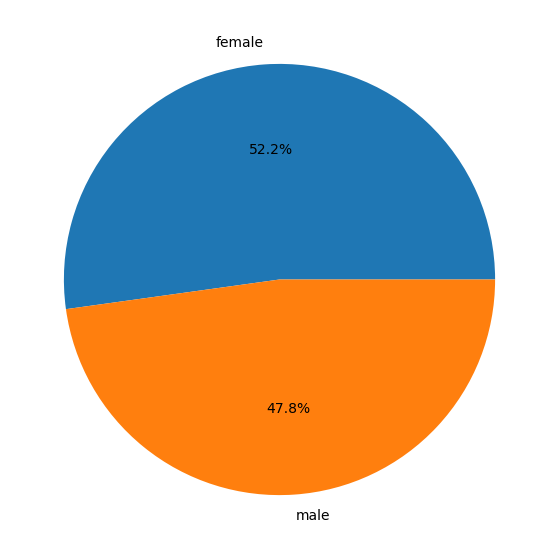

In [61]:
show_user_gender_pie_en()

In [76]:
def show_users_gender_countplot():
    import arabic_reshaper 
    from bidi.algorithm import get_display 
    df = get_user_profile() 
    if df.empty:
        print("No user data available to generate gender pie chart.")
        return
    df['gender'] = df['gender'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
    X = df['gender'].value_counts()
 
    plt.figure(figsize=(10,7))
    plt.title('User Gender Count')
    ax = sns.countplot(data=df,x='gender', hue='gender',palette='viridis')
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()

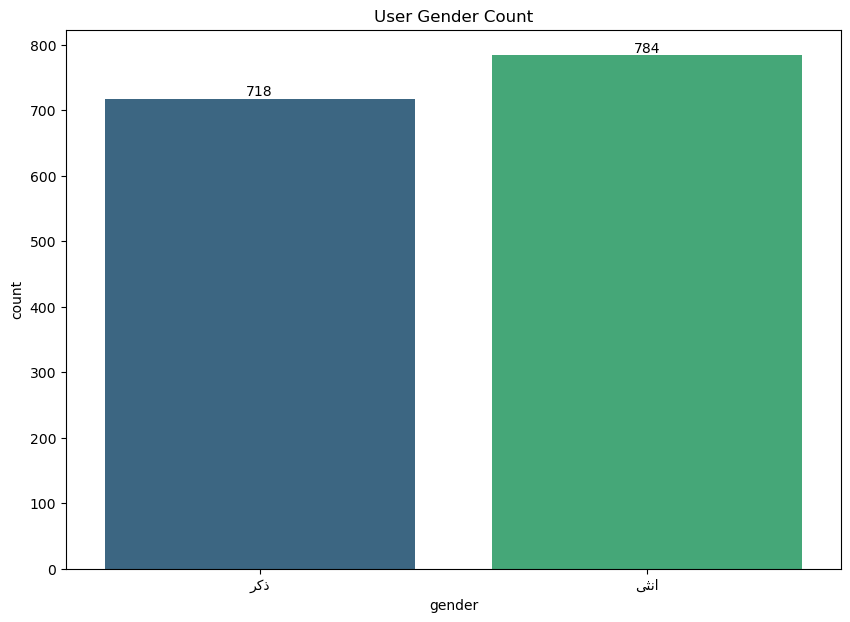

In [77]:
show_users_gender_countplot()